<a href="https://colab.research.google.com/github/JinHuiXu1991/Jin_DATA606/blob/main/ipynb/DATA606_Part2_CollaborativeRecommender.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Product Recommender Systems
## Author: Jin Hui Xu

#Collaborative Filtering 

Collaborative methods for recommender systems are methods based on past interactions recorded between users 
and items to generate new recommendations. These interactions are stored in the so-called “user-item interactions 
matrix.” The past user-item interactions represent the bases to detect similar users and/or similar items and to 
make predictions based on estimated proximities

The class of collaborative filtering algorithms is divided into two sub-categories called memory-based and 
model-based approaches: 
* Memory-based approaches directly work with values of recorded interactions, assuming no model, and 
are essentially based on nearest neighbors search or KNN (i.e., find the closest users from a referenced 
user and suggest the most popular items among these neighbors)
* Model-based approaches assume there is an underlying “generative” model that explains the user-item 
interactions and tries to identify it in order to make new predictions

In [ ]:
!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_product.zip?raw=true

!wget https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_review.zip?raw=true

--2022-04-22 02:51:55--  https://github.com/JinHuiXu1991/Jin_DATA606/blob/main/cleaned_data/cleaned_amazon_product.zip?raw=true
Resolving github.com (github.com)... 192.30.255.112
Connecting to github.com (github.com)|192.30.255.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/cleaned_data/cleaned_amazon_product.zip [following]
--2022-04-22 02:51:55--  https://github.com/JinHuiXu1991/Jin_DATA606/raw/main/cleaned_data/cleaned_amazon_product.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/cleaned_data/cleaned_amazon_product.zip [following]
--2022-04-22 02:51:55--  https://raw.githubusercontent.com/JinHuiXu1991/Jin_DATA606/main/cleaned_data/cleaned_amazon_product.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.

In [ ]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 2.7 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1630176 sha256=ed6bc3eda336ca67e6316ceed3d3ac69ccc669beb96ba8be71ef2ef742b26583
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split as train_test_split2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import linear_kernel
from surprise import dump
import os
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import SVDpp
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise.accuracy import rmse
from surprise.model_selection import GridSearchCV
import gzip
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import nltk

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
review_df = pd.read_csv('/content/cleaned_amazon_review.zip?raw=true', compression='zip')

review_df.head()

,overall,reviewTime,reviewerID,asin,reviewText,summary,reviewTimeYear,reviewTimeMonth
0,5.0,2013-11-27,A3NHUQ33CFH3VM,1118461304,not one thing in this book seemed an obvious o...,clear on what leads to innovation,2013,11
1,5.0,2013-11-01,A3SK6VNBQDNBJE,1118461304,i have enjoyed dr alan gregerman s weekly blog...,becoming more innovative by opening yourself t...,2013,11
2,5.0,2013-10-10,A3SOFHUR27FO3K,1118461304,alan gregerman believes that innovation comes ...,the world from different perspectives,2013,10
3,5.0,2013-10-09,A1HOG1PYCAE157,1118461304,alan gregerman is a smart funny entertaining w...,strangers are your new best friends,2013,10
4,5.0,2013-09-07,A26JGAM6GZMM4V,1118461304,as i began to read this book i was again remin...,how and why it is imperative to engage learn f...,2013,9


In [ ]:
#Remove all information except Reviewer ID, Product ID and rating
review_df = review_df[['reviewerID', 'asin', 'overall']]

In [ ]:
product_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')

product_df.head()

,category,description,title,brand,feature,main_cat,date,price,asin,imageURLHighRes,dateYear,dateMonth,ori_title
0,"Appliances Refrigerators, Freezers & Ice Makers",NaN,tupperware freezer square round container set ...,tupperware,each 3 pc set includes two 7 8 cup 200 ml and ...,appliances,2008-11-19,NaN,7301113188,[],2008,11,Tupperware Freezer Square Round Container Set ...
1,"Appliances Refrigerators, Freezers & Ice Makers",2 x tupperware pure fresh unique covered cool ...,2 x tupperware pure amp fresh unique covered c...,tupperware,2 x tupperware pure fresh unique covered cool ...,appliances,2016-06-05,3.62,7861850250,['https://images-na.ssl-images-amazon.com/imag...,2016,6,2 X Tupperware Pure &amp; Fresh Unique Covered...
2,Appliances Parts & Accessories,NaN,the cigar moments of pleasure,the cigar book,NaN,amazon home,NaN,150.26,8792559360,['https://images-na.ssl-images-amazon.com/imag...,0,0,The Cigar - Moments of Pleasure
3,Appliances Parts & Accessories,multi purpost descaler especially suited to wa...,caraselle 2x 50g appliance descalene,caraselle,NaN,tools home improvement,2014-12-17,NaN,9792954481,['https://images-na.ssl-images-amazon.com/imag...,2014,12,Caraselle 2X 50G Appliance Descalene
4,Appliances Parts & Accessories Range Parts & A...,full gauge and size beveled edge furnished wit...,eaton wiring 39ch sp l arrow hart 1 gang chrom...,eaton wiring,returns will not be honored on this closeout i...,tools home improvement,2007-01-16,3.43,B00002N5EL,[],2007,1,EATON Wiring 39CH-SP-L Arrow Hart 1-Gang Chrom...


In [ ]:
#Remove all information except Product ID and title
product_df = product_df[['asin']]

In [ ]:
merged_df = review_df.merge(product_df, on='asin', how='inner')
merged_df.head()

,reviewerID,asin,overall
0,A3SHVDMM83IHJ4,B00002N7IL,5.0
1,A3TIWHNJXMSIU7,B00002N7IL,5.0
2,AVP16JFIT6LPL,B00002N7IL,5.0
3,A2J2T9LX2HC947,B00002N7IL,5.0
4,AJN26F4KMWD59,B00002N7IL,5.0


In [ ]:
merged_df = merged_df.groupby("reviewerID").filter(lambda x: len(x) > 2)

In [ ]:
merged_df.shape

(49758, 3)

In [ ]:
#Assign X as the original ratings dataframe and y as the user_id column of ratings.
X = merged_df.copy()
y = merged_df['reviewerID']

#Split into training and test datasets, stratified along user_id
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)

In [ ]:
#Function that computes the RMSE
def custom_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def baseline(reviewer_id, product_id):
    return 3.0

In [ ]:
def score(cf_model):
    
    #Construct a list of user-movie tuples from the testing dataset
    id_pairs = zip(X_test['reviewerID'], X_test['asin'])
    
    #Predict the rating for every user-movie tuple
    y_pred = np.array([cf_model(reviewer, product) for (reviewer, product) in id_pairs])
    
    #Extract the actual ratings given by the users in the test data
    y_true = np.array(X_test['overall'])
    
    #Return the final RMSE score
    return custom_rmse(y_true, y_pred)

In [ ]:
score(baseline)

1.821168105646662

The baseline model has an RMSE score of 1.82, and it can be used to evaluate other models' performances. The model's RMSE score should be less than this value to be considered a good performance.

## Memory Based


### Rating Matrix

In [ ]:
r_matrix = X_train.pivot_table(values='overall', index='reviewerID', columns='asin')

r_matrix

asin,B00002N7HY,B00002N7IL,B00002NARC,B00004SQHD,B00004YWK2,B00004YWK7,B00005OU6T,B00006IV17,B00007E7RQ,B00007E7RZ,...,B01HHFUBCC,B01HHFUCMG,B01HHFUCVW,B01HHFUD1G,B01HHFUDAC,B01HICGMWC,B01HIQV5DE,B01HJGWMTO,B01HJH0KLK,B01HJHHQM6
reviewerID,,,,,,,,,,,,,,,,,,,,,
A07936821FOVJO6NP4Q8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0954586PW98I9TNZXJP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1000EWBXBHK0P,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100Q352397DAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100U4YIZTKJ56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZYLZ9TUBG4LR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZYW2VXM8Z2QH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZZHU3J9S09K4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
#User Based Collaborative Filter using Mean Ratings
def cf_user_mean(reviewer_id, product_id):
    
    #Check if product id exists in r_matrix
    if product_id in r_matrix:
        #Compute the mean of all the ratings given to the product
        mean_rating = r_matrix[product_id].mean()
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        mean_rating = 3.0
    
    return mean_rating

In [ ]:
#Compute RMSE for the Mean model
score(cf_user_mean)

1.1634864033878112

### Weighted Mean

In [ ]:
r_matrix_dummy = r_matrix.copy().fillna(0)

In [ ]:
r_matrix_dummy

asin,B00002N7HY,B00002N7IL,B00002NARC,B00004SQHD,B00004YWK2,B00004YWK7,B00005OU6T,B00006IV17,B00007E7RQ,B00007E7RZ,...,B01HHFUBCC,B01HHFUCMG,B01HHFUCVW,B01HHFUD1G,B01HHFUDAC,B01HICGMWC,B01HIQV5DE,B01HJGWMTO,B01HJH0KLK,B01HJHHQM6
reviewerID,,,,,,,,,,,,,,,,,,,,,
A07936821FOVJO6NP4Q8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0954586PW98I9TNZXJP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1000EWBXBHK0P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100Q352397DAN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100U4YIZTKJ56,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZYLZ9TUBG4LR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZYW2VXM8Z2QH,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AZZHU3J9S09K4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#Compute the cosine similarity matrix using the dummy ratings matrix
cosine_sim = cosine_similarity(r_matrix_dummy, r_matrix_dummy)

In [ ]:
cosine_sim = pd.DataFrame(cosine_sim, index=r_matrix.index, columns=r_matrix.index)

cosine_sim

reviewerID,A07936821FOVJO6NP4Q8,A0954586PW98I9TNZXJP,A1000EWBXBHK0P,A100Q352397DAN,A100U4YIZTKJ56,A100UD67AHFODS,A100WO06OQR8BQ,A101AF3PWTCCFZ,A102MK78XH84JN,A102VBZJRLHRHZ,...,AZVZXY07QD5D0,AZWOQXRCS1WA6,AZWVR4Y150V6L,AZXE7L2Q0E0CM,AZYHU1SCZT27T,AZYLZ9TUBG4LR,AZYW2VXM8Z2QH,AZZHU3J9S09K4,AZZRNGKUZKVIC,AZZV9PDNMCOZW
reviewerID,,,,,,,,,,,,,,,,,,,,,
A07936821FOVJO6NP4Q8,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0954586PW98I9TNZXJP,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A1000EWBXBHK0P,0.0,0.0,1.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100Q352397DAN,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100U4YIZTKJ56,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZYLZ9TUBG4LR,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
AZYW2VXM8Z2QH,0.0,0.0,0.0,0.0,0.0,0.0,0.161296,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
AZZHU3J9S09K4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
#User Based Collaborative Filter using Weighted Mean Ratings
def cf_user_wmean(reviewer_id, product_id):
    
    #Check if movie_id exists in r_matrix
    if product_id in r_matrix:
        
        #Get the similarity scores for the user in question with every other user
        sim_scores = cosine_sim[reviewer_id]
        
        #Get the user ratings for the product in question
        m_ratings = r_matrix[product_id]
        
        #Extract the indices containing NaN in the m_ratings series
        idx = m_ratings[m_ratings.isnull()].index
        
        #Drop the NaN values from the m_ratings Series
        m_ratings = m_ratings.dropna()
        
        #Drop the corresponding cosine scores from the sim_scores series
        sim_scores = sim_scores.drop(idx)
        
        #Compute the final weighted mean
        if sim_scores.sum() == 0.0:
          wmean_rating = 3.0
        else:
          wmean_rating = np.dot(sim_scores, m_ratings)/ sim_scores.sum()
    
    else:
        #Default to a rating of 3.0 in the absence of any information
        wmean_rating = 3.0
    
    return wmean_rating

In [ ]:
score(cf_user_wmean)

1.5632708277857408

The memory-based cosine similarity approach for both rating mean and weight rating mean is not performing very well. Besides, due to the computing limitation, we are not able to deploy a memory-based model for the Web API, let's explore the model-based model below.

## Model Based

### Review Rating

For training the collaborative filtering model, we only consider the customer with at least 3 reviews in our dataset. This will increase the recommendation output accuracy.

In [ ]:
merged_df2 = review_df.merge(product_df, on='asin', how='inner')
merged_df2 = merged_df2.groupby("reviewerID").filter(lambda x: len(x) > 2)
merged_df2.shape

(49758, 3)

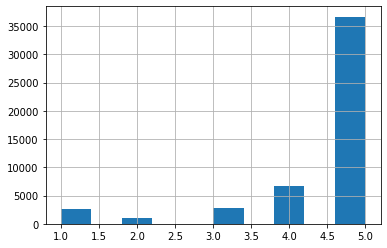

In [ ]:
merged_df2["overall"].hist()

In [ ]:
benchmark = []
reader = Reader()
# Iterate over all algorithms
data = Dataset.load_from_df(merged_df2, reader)
algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f3e13929f50>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f3e13929f50> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f3e13929ed0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f3e13929ed0> 


Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7f3e13744d90>
Done:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7f3e13744d90> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f3e1373ed90>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f3e1373ed90> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f3e1371ba10>
Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f3e1371ba10> 


Starting:  <surprise.prediction_algorithms.knns.KNNBaseline object 

In [ ]:
surprise_results = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.947027,7.495496,0.243215
SVD,0.962581,2.144800,0.102320
BaselineOnly,0.982409,0.118954,0.091102
KNNBaseline,0.985566,5.899654,0.763769
KNNBasic,1.035306,5.607490,0.829671
KNNWithMeans,1.052519,5.863409,0.748799
KNNWithZScore,1.056320,6.105625,0.779528
SlopeOne,1.065440,2.179806,0.128903
CoClustering,1.072671,2.283785,0.054498


Perform GridSearchCV to find the best parameters for the model

In [ ]:
param_grid = {
    "n_epochs": [10, 20, 30, 40, 50],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.02, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], refit=True, cv=5, n_jobs=5)
gs.fit(data)

# save the best parameters
training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.9191473055736857
BEST params: 	 {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.1}


In [ ]:
data = Dataset.load_from_df(merged_df2, reader)

# use the best parameters to train our SVD model
svd = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

# do some cross_validate for the dataset and see the rmse score
cross_validate(svd, data, measures=['rmse'], cv=10, verbose=True)

Evaluating RMSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.9240  0.9154  0.8904  0.9273  0.9063  0.8999  0.9320  0.9038  0.9000  0.9126  0.9112  0.0128  
Fit time          5.77    5.68    5.95    5.96    5.79    5.70    5.78    5.85    5.87    6.01    5.84    0.10    
Test time         0.03    0.03    0.04    0.03    0.03    0.03    0.04    0.03    0.03    0.04    0.03    0.00    


{'fit_time': (5.770456790924072,
  5.683258533477783,
  5.9537553787231445,
  5.957347631454468,
  5.786940097808838,
  5.702826499938965,
  5.7793354988098145,
  5.846249341964722,
  5.865283250808716,
  6.006083726882935),
 'test_rmse': array([0.92397927, 0.91535011, 0.89044899, 0.92734063, 0.90629655,
        0.89989506, 0.93204426, 0.90380216, 0.90004889, 0.9126164 ]),
 'test_time': (0.03405904769897461,
  0.032875776290893555,
  0.0359654426574707,
  0.03239727020263672,
  0.03321409225463867,
  0.033968210220336914,
  0.03647160530090332,
  0.03352022171020508,
  0.03477907180786133,
  0.037301063537597656)}

The average RMSE score is 0.91 which is the best among all other algorithms.

In [ ]:
# train our final SVD model
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
model_filename = "./cr_model.pickle"

# save trained model and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=svd)


In [ ]:
def load_model(model_filename):
    file_name = os.path.expanduser(model_filename)
    _, loaded_model = dump.load(file_name)
    return loaded_model

In [ ]:
from collections import defaultdict
def collaborative_SVD_recommender(predictions, product_df):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, _, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:10]

    for uid, user_ratings in top_n.items():
      result = [iid for (iid, _) in user_ratings]

    return result, product_df[product_df['asin'].isin(result)]['ori_title'].tolist()

In [ ]:
def get_rec_user(uid, input_df):
  input_id = uid
  data1 = [input_id]
  data2 = input_df['asin'].unique().tolist()

  df = pd.DataFrame(data1)
  df.columns =['reviewerID']

  df1 = pd.DataFrame(data2)
  df1.columns =['asin']
  # filter out reviewed products
  reviewed_product = input_df[input_df['reviewerID'] == input_id].asin.unique().tolist()
  df1 = df1[~df1['asin'].isin(reviewed_product)]

  # Now to perform cross join, we will create
  # a key column in both the DataFrames to
  # merge on that key.
  df['key'] = 1
  df1['key'] = 1

  # to obtain the cross join we will merge
  # on the key and drop it.
  result = pd.merge(df, df1, on ='key')

  result['overall']=0.0
  del result['key']
  return result


In [ ]:
model_filename = "./cr_model.pickle"
loaded_model = load_model(model_filename)

result_list = []
title_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')

input_id = 'A1CY6CQC5HPQGL'
result = get_rec_user(input_id, merged_df2)
valid_Dataset = Dataset.load_from_df(result, reader)

testset = valid_Dataset.df.values.tolist()
predictions = loaded_model.test(testset)


asin, title = collaborative_SVD_recommender(predictions, title_df)
for i in range(0, 10):
  result_list.append((input_id, asin[i], title[i]))



In [ ]:
result_df = pd.DataFrame(result_list)
result_df.columns = ['reviewerID', 'asin', 'ori_title']

In [ ]:
reviewer_input_id = 'A1CY6CQC5HPQGL'

In [ ]:
print('Collaborative Recommender Result for customer {}: '.format(reviewer_input_id))

for i, product in enumerate(result_df.values.tolist()):
  print('{}. {}, {}'.format(i+1, product[1], product[2]))

Collaborative Recommender Result for customer A1CY6CQC5HPQGL: 
1. B00009W3PL, Certified Appliance Accessories 3-Wire Closed-Eyelet 50-Amp Range Cord, 5ft
2. B0000TN7NS, Vicks Humidity Monitor Helps You Keep Moisture at Ideal Levels
3. B0002YTLYU, Broan 423608 ADA Capable Under-Cabinet Range Hood, 190 CFM 36-Inch, Almond
4. B0006OQCFW, BestAir D13, Honeywell Replacement, Paper Wick Humidifier Filter, 5.9&quot; x 1.9&quot; x 7.9&quot;
5. B00097A4J6, Whirlpool : ECKMF94 Automatic Ice Maker Kit
6. B0009H6094, Kaz WF1 Humidifier Filter (Aftermarket)
7. B0009H7CAU, Accumulair Hunter 31943 Humidifier Filter (Aftermarket)
8. B000BP7MMS, Broan BP58 Non-Ducted Charcoal Replacement Filter Pads for Range Hood, 7-3/4 by 10-1/2-Inch, 3-Pack
9. B000BQ8D7A, Southwire 09016 50-Amp 3-Wire Range Power Cord, 6-Foot
10. B000BQQ4D0, Broan Model BPQTF Non-Ducted Range Hood Filter


### Review Text Sentiment

Since one of the objectives of this project is to find out if textual data can improve recommender systems' performance, we can perform sentiment analysis against the review text and convert the sentiment polarity score into the same range as the review rating. 

In [ ]:
review_df2 = pd.read_csv('/content/cleaned_amazon_review.zip?raw=true', compression='zip')

review_df2['all_review_text'] = review_df2['reviewText'] + review_df2['summary']

In [ ]:
#Remove all information except Reviewer ID, Product ID and text
review_df2 = review_df2[['reviewerID', 'asin', 'all_review_text']]

In [ ]:
review_df2.isnull().sum()

reviewerID           0
asin                 0
all_review_text    437
dtype: int64

In [ ]:
review_df2 = review_df2.fillna('')
review_df2.isnull().sum()

reviewerID         0
asin               0
all_review_text    0
dtype: int64

In [ ]:
merged_df3 = review_df2.merge(product_df, on='asin', how='inner')
merged_df3 = merged_df3.groupby("reviewerID").filter(lambda x: len(x) > 2)
merged_df3.shape

(49758, 3)

In [ ]:
merged_df3

,reviewerID,asin,all_review_text
1,A3TIWHNJXMSIU7,B00002N7IL,this particular type is perfect and easily ada...
2,AVP16JFIT6LPL,B00002N7IL,excellentfive stars
23,A22U6Z2M9TO90N,B00004SQHD,cheaper than locally cant go wrong five stars
30,A11QC8XY4UEWI7,B00004SQHD,used for my bosch ev car charger so it is not ...
63,A1ISAGPQ7AIBY1,B00004YWK2,worksworks
...,...,...,...
601565,ANTWC02YFFY2U,B01HFYY7ZW,does what it says and is accurate great little...
601584,A23ZRF0IE2E12G,B01HHBKZTA,cheap price and works a job not for the faint ...
601604,AKYJGJSMJMGRS,B01HJH0KLK,the original one lasted about 3 years then i r...
601617,A76BRLOWSD88F,B01HJHHQM6,perfect fit knob job


In [ ]:
# Tokenize, stem, and lemmatize the text
stop = stopwords.words('english')
def preprocess(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text.lower())
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized

porter = PorterStemmer()
def stem(input):
    return [porter.stem(word) for word in input]

lem = WordNetLemmatizer()
def lemma(input):
    return [lem.lemmatize(w) for w in input]

In [ ]:
merged_df3['all_review_text'] = merged_df3['all_review_text'].apply(preprocess)
merged_df3['all_review_text'] = merged_df3['all_review_text'].apply(stem)
merged_df3['all_review_text'] = merged_df3['all_review_text'].apply(lemma)

In [ ]:
def token_to_sen(input):
    return ' '.join(input)
    
merged_df3['all_review_text'] = merged_df3['all_review_text'].apply(token_to_sen)


In [ ]:
def sentiment_analysis(input):
  testimonial = TextBlob(input)
  return testimonial.polarity

In [ ]:
merged_df3['polarity'] = merged_df3['all_review_text'].apply(sentiment_analysis)

In [ ]:
del merged_df3['all_review_text']

In [ ]:
merged_df3

,reviewerID,asin,polarity
1,A3TIWHNJXMSIU7,B00002N7IL,0.498667
2,AVP16JFIT6LPL,B00002N7IL,0.000000
23,A22U6Z2M9TO90N,B00004SQHD,-0.250000
30,A11QC8XY4UEWI7,B00004SQHD,0.225000
63,A1ISAGPQ7AIBY1,B00004YWK2,0.000000
...,...,...,...
601565,ANTWC02YFFY2U,B01HFYY7ZW,0.800000
601584,A23ZRF0IE2E12G,B01HHBKZTA,0.072000
601604,AKYJGJSMJMGRS,B01HJH0KLK,-0.033333
601617,A76BRLOWSD88F,B01HJHHQM6,0.700000


Now we get the sentiment polarity score for each review, let's convert them into the same range as review rating

In [ ]:
def convert_range(input):
  OldRange = (1 - (-1))  
  NewRange = (5 - 1)  
  NewValue = (((input - (-1)) * NewRange) / OldRange) + 1
  return NewValue

In [ ]:
merged_df3["rate_by_polarity"] = merged_df3['polarity'].apply(convert_range)

In [ ]:
del merged_df3['polarity']

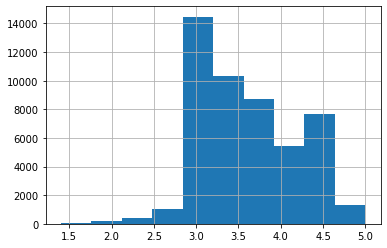

In [ ]:
merged_df3["rate_by_polarity"].hist()

The graph shows that based on the sentiment of the review text, the rating distribution should not be that imbalanced.

In [ ]:
benchmark = []
reader = Reader()
# Iterate over all algorithms
data = Dataset.load_from_df(merged_df3, reader)
algorithms = [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]

for algorithm in algorithms:
    print("Starting: " ,str(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data, measures=['RMSE'], cv=5, verbose=False)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    print("Done: " ,str(algorithm), "\n\n")

Starting:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f3df3c1ad10>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x7f3df3c1ad10> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f3df3c168d0>
Done:  <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x7f3df3c168d0> 


Starting:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7f3df3c78b10>
Done:  <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x7f3df3c78b10> 


Starting:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f3df3c0e110>
Done:  <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x7f3df3c0e110> 


Starting:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f3df3c247d0>
Done:  <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x7f3df3c247d0> 


Starting:  <surprise.prediction_algorithms.knns.KNNBaseline object 

In [ ]:
surprise_results = pd.DataFrame(benchmark).sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time,Algorithm
1,0.570962,7.235222,0.225179,SVDpp
0,0.577325,2.171684,0.069904,SVD
9,0.581488,0.129146,0.046562,BaselineOnly
5,0.591287,5.741593,0.804107,KNNBaseline
6,0.615071,5.544654,0.778922,KNNBasic
7,0.637690,5.649759,0.762275,KNNWithMeans
8,0.640280,5.923294,0.777118,KNNWithZScore
2,0.660248,2.148028,0.123483,SlopeOne
3,0.743142,3.774009,0.104871,NMF
10,0.752756,2.216395,0.048579,CoClustering


Perform GridSearchCV to find the best parameters for the model

In [ ]:
param_grid = {
    "n_epochs": [10, 20, 30, 40, 50],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.02, 0.1]
}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], refit=True, cv=5, n_jobs=5)
gs.fit(data)

# save the best parameters
training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.5657706192423642
BEST params: 	 {'n_epochs': 40, 'lr_all': 0.01, 'reg_all': 0.1}


In [ ]:
data = Dataset.load_from_df(merged_df3, reader)

# use the best parameters to train our SVD model
svd = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

# do some cross_validate for the dataset and see the rmse score
cross_validate(svd, data, measures=['rmse'], cv=10, verbose=True)

Evaluating RMSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.5568  0.5659  0.5587  0.5524  0.5565  0.5711  0.5674  0.5604  0.5670  0.5533  0.5609  0.0062  
Fit time          4.60    4.47    4.41    4.40    4.39    4.40    4.49    4.40    4.40    4.45    4.44    0.06    
Test time         0.03    0.03    0.36    0.03    0.03    0.03    0.03    0.04    0.03    0.04    0.07    0.10    


{'fit_time': (4.595636606216431,
  4.465399742126465,
  4.406850576400757,
  4.404946804046631,
  4.385076284408569,
  4.400797128677368,
  4.48804235458374,
  4.397135019302368,
  4.397047519683838,
  4.44511866569519),
 'test_rmse': array([0.55675374, 0.56585745, 0.55872814, 0.55242237, 0.55647443,
        0.5710595 , 0.56744118, 0.56041249, 0.56704556, 0.55326162]),
 'test_time': (0.0326085090637207,
  0.03234219551086426,
  0.35570621490478516,
  0.03398466110229492,
  0.032607078552246094,
  0.03413963317871094,
  0.03479647636413574,
  0.037779808044433594,
  0.03294014930725098,
  0.035216569900512695)}

In [ ]:
# train SVD model
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
model_filename = "./cr_sentiment_model.pickle"

# save trained model and reload it.
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=svd)

In [ ]:
model_filename = "./cr_sentiment_model.pickle"
loaded_model = load_model(model_filename)

result_list = []
title_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')

input_id = 'A1CY6CQC5HPQGL'
result = get_rec_user(input_id, merged_df3)
valid_Dataset = Dataset.load_from_df(result, reader)

testset = valid_Dataset.df.values.tolist()
predictions = loaded_model.test(testset)


asin, title = collaborative_SVD_recommender(predictions, title_df)
for i in range(0, 10):
  result_list.append((input_id, asin[i], title[i]))


In [ ]:
result_df = pd.DataFrame(result_list)
result_df.columns = ['reviewerID', 'asin', 'ori_title']

In [ ]:
reviewer_input_id = 'A1CY6CQC5HPQGL'

print('Collaborative Recommender Result for customer {}: '.format(reviewer_input_id))

for i, product in enumerate(result_df.values.tolist()):
  print('{}. {}, {}'.format(i+1, product[1], product[2]))

Collaborative Recommender Result for customer A1CY6CQC5HPQGL: 
1. B002YTOCP4,  Whirlpool Part Number Y61372
2. B00DNCHMDA, Whirlpool Part Number 8181673: Gasket, Tub
3. B00M08ONE4, Whirlpool 4392899 Paint Touch-Up
4. B00EXQ3VVM, Replacement LG 5221ER1003A Washer Cold Water Valve
5. B00LQDIZL6, 21001932 - Maytag Washer / Washing Machine Inlet Water Valve Replacement
6. B00LQDA9HY, Whirlpool 305448 Dryer Timer
7. B001DPVPAA, Whirlpool W10469286 Icemaker Assembly
8. B00L5G5KLM, Whirlpool W10247306 Valve Replacement
9. B00VKFVAYE, Supco SM8549 Evaporator Motor Kit
10. B00DM8L4K2, Edgewater Parts 5301EL1001A Dryer Heater Assembly Compatible With LG Dryer


###Deep Learning

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings

from keras.layers import Input, Embedding, Flatten, Dot, Dense, Concatenate
from keras.models import Model
import tensorflow as tf
warnings.filterwarnings('ignore')
%matplotlib inline
from keras.models import load_model



Neural network only takes integer input, map our reviewer IDs and product IDs to indexes 

In [ ]:
reviwer_dataframe = pd.DataFrame(review_df2.reviewerID.unique())   
reviwer_dataframe.reset_index(inplace=True)
reviwer_dataframe = reviwer_dataframe.rename(columns={'index':'reviewerIndex', 0:'reviewerID'})

In [ ]:
reviwer_dataframe

,reviewerIndex,reviewerID
0,0,A3NHUQ33CFH3VM
1,1,A3SK6VNBQDNBJE
2,2,A3SOFHUR27FO3K
3,3,A1HOG1PYCAE157
4,4,A26JGAM6GZMM4V
...,...,...
515645,515645,A36AFG744ESS53
515646,515646,A24A9P4F2SLTK5
515647,515647,A2JCB4KHBWEELW
515648,515648,A1LDYYVTLPP2Z5


In [ ]:
product_dataframe = pd.DataFrame(review_df2.asin.unique())   
product_dataframe.reset_index(inplace=True)
product_dataframe = product_dataframe.rename(columns={'index':'productIndex', 0:'asin'})

In [ ]:
product_dataframe

,productIndex,asin
0,0,1118461304
1,1,B00002N7IL
2,2,B00004SQHD
3,3,B00004YWK2
4,4,B00004YWK7
...,...,...
30247,30247,B01HJHHQM6
30248,30248,B01HJGWMTO
30249,30249,B01HJH2PY0
30250,30250,B01HJHHEA0


In [ ]:
n_merged_df = merged_df3.merge(reviwer_dataframe, on='reviewerID', how='left')
n_merged_df = n_merged_df.merge(product_dataframe, on='asin', how='left')

In [ ]:
n_merged_df

,reviewerID,asin,rate_by_polarity,reviewerIndex,productIndex
0,A3TIWHNJXMSIU7,B00002N7IL,3.997333,43015,1
1,AVP16JFIT6LPL,B00002N7IL,3.000000,12019,1
2,A22U6Z2M9TO90N,B00004SQHD,2.500000,48,2
3,A11QC8XY4UEWI7,B00004SQHD,3.450000,55,2
4,A1ISAGPQ7AIBY1,B00004YWK2,3.000000,78,3
...,...,...,...,...,...
49753,ANTWC02YFFY2U,B01HFYY7ZW,4.600000,24759,30224
49754,A23ZRF0IE2E12G,B01HHBKZTA,3.144000,216554,30230
49755,AKYJGJSMJMGRS,B01HJH0KLK,2.933333,393173,30241
49756,A76BRLOWSD88F,B01HJHHQM6,4.400000,86087,30247


In [ ]:
train, test = train_test_split(n_merged_df, test_size=0.2, random_state=42)

In [ ]:
n_products = len(n_merged_df.productIndex.unique())
n_products

9848

In [ ]:
n_reviewers = len(n_merged_df.reviewerIndex.unique())
n_reviewers


13239

In [ ]:
# creating products embedding path
product_input = Input(shape=[1], name="Product-Input")
product_embedding = Embedding(n_products+1, 5, name="Product-Embedding")(product_input)
product_vec = Flatten(name="Flatten-Products")(product_embedding)

# creating reviewers embedding path
reviewers_input = Input(shape=[1], name="Reviewer-Input")
reviewers_embedding = Embedding(n_reviewers+1, 5, name="Reviewer-Embedding")(reviewers_input)
reviewers_vec = Flatten(name="Flatten-Reviewers")(reviewers_embedding)

# concatenate features
conc = Concatenate()([product_vec, reviewers_vec])

# add fully-connected-layers
fc1 = Dense(128, activation='relu')(conc)
fc2 = Dense(32, activation='relu')(fc1)
out = Dense(1)(fc2)

# Create model and compile it
model2 = Model([reviewers_input, product_input], out)
#model2.compile('adam', 'mean_squared_error')
model2.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=[tf.keras.metrics.RootMeanSquaredError()])

Epoch 1/15
1244/1244 [==============================] - 7s 3ms/step - loss: 0.7904 - root_mean_squared_error: 0.8890
Epoch 2/15
1244/1244 [==============================] - 4s 3ms/step - loss: 0.3495 - root_mean_squared_error: 0.5911
Epoch 3/15
1244/1244 [==============================] - 4s 3ms/step - loss: 0.3344 - root_mean_squared_error: 0.5783
Epoch 4/15
1244/1244 [==============================] - 4s 3ms/step - loss: 0.3268 - root_mean_squared_error: 0.5717
Epoch 5/15
1244/1244 [==============================] - 5s 4ms/step - loss: 0.3218 - root_mean_squared_error: 0.5673
Epoch 6/15
1244/1244 [==============================] - 4s 3ms/step - loss: 0.3174 - root_mean_squared_error: 0.5633
Epoch 7/15
1244/1244 [==============================] - 4s 3ms/step - loss: 0.3149 - root_mean_squared_error: 0.5612
Epoch 8/15
1244/1244 [==============================] - 4s 3ms/step - loss: 0.3125 - root_mean_squared_error: 0.5591
Epoch 9/15
1244/1244 [==============================] - 4s 3ms/s

Text(0, 0.5, 'Training Error')

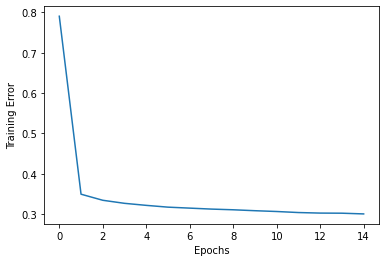

In [ ]:
history = model2.fit([train.reviewerIndex, train.productIndex], train.rate_by_polarity, epochs=15, verbose=1)
model2.save('deep_model.h5')
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training Error")

In [ ]:
deep_result = model2.evaluate([test.reviewerIndex, test.productIndex], test.rate_by_polarity)
deep_result

311/311 [==============================] - 1s 2ms/step - loss: 0.4094 - root_mean_squared_error: 0.6398


[0.40939635038375854, 0.6398409008979797]

In [ ]:
deep_result[1]

0.6398409008979797

In [ ]:
new_row = {'test_rmse':deep_result[1], 'fit_time':np.NaN, 'test_time':np.NaN, 'Algorithm':'Neural Network'}
#append row to the dataframe
surprise_results = surprise_results.append(new_row, ignore_index=True)
surprise_results = surprise_results.set_index('Algorithm').sort_values('test_rmse')
surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.570962,7.235222,0.225179
SVD,0.577325,2.171684,0.069904
BaselineOnly,0.581488,0.129146,0.046562
KNNBaseline,0.591287,5.741593,0.804107
KNNBasic,0.615071,5.544654,0.778922
KNNWithMeans,0.637690,5.649759,0.762275
Neural Network,0.639841,NaN,NaN
KNNWithZScore,0.640280,5.923294,0.777118
SlopeOne,0.660248,2.148028,0.123483


This is the final result list for all the algorithms, the table shows that SVDpp and SVD have a very close performance, but the training and testing time of SVDpp is longer than SVD.

##Deployment Model (SVD - Review Text Sentiment)

In the model selection section above, the model SVD with the review text sentiment polarity score has the best performance, so we will use this model for the collaborative filtering recommendation model deployment.

Since the limited server's RAM and storage capacity, we are not able to train a model with the entire reviewer dataset, instead, we select the reviewers with at least 2 review records. 

It will help meet the computing resource requirement but also can better capture the similar user because capturing similarities of the reviewers by only 1 review record will affect the model's performance. For the missing reviewers in the collaborative filtering model, the recommendation will be handled by the content-based filtering model which will be integrated into the final hybrid recommendation system.

In [ ]:
final_merged_df = review_df2.merge(product_df, on='asin', how='inner')
final_merged_df = final_merged_df.groupby("reviewerID").filter(lambda x: len(x) > 1)
final_merged_df.shape

(150090, 3)

In [ ]:
final_merged_df

,reviewerID,asin,all_review_text
1,A3TIWHNJXMSIU7,B00002N7IL,this particular type is perfect and easily ada...
2,AVP16JFIT6LPL,B00002N7IL,excellentfive stars
3,A2J2T9LX2HC947,B00002N7IL,yea babyfive stars
8,A1C6CXABMGKW1V,B00002N7IL,leviton has top notch products thanks leviton
10,A5OV35IHA1I9D,B00002N7IL,meets expectations and easy installation five ...
...,...,...,...
601595,AYVTXXMCAFXU0,B01HIF4LIQ,excellent productfive stars
601604,AKYJGJSMJMGRS,B01HJH0KLK,the original one lasted about 3 years then i r...
601617,A76BRLOWSD88F,B01HJHHQM6,perfect fit knob job
601619,AMFP48Y9OFUIZ,B01HJGWMTO,it s a little expensive but it s a true replac...


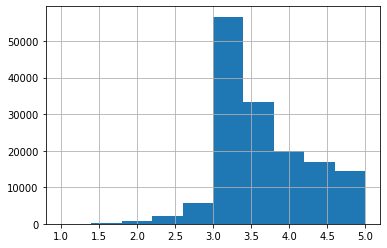

In [ ]:
# preprocess the review text and convert it into sentiment polarity score.

final_merged_df['all_review_text'] = final_merged_df['all_review_text'].apply(preprocess)
final_merged_df['all_review_text'] = final_merged_df['all_review_text'].apply(stem)
final_merged_df['all_review_text'] = final_merged_df['all_review_text'].apply(lemma)
final_merged_df['all_review_text'] = final_merged_df['all_review_text'].apply(token_to_sen)
final_merged_df['polarity'] = final_merged_df['all_review_text'].apply(sentiment_analysis)
del final_merged_df['all_review_text']

# convert sentiment polarity score range to [1, 5]
final_merged_df["rate_by_polarity"] = final_merged_df['polarity'].apply(convert_range)
del final_merged_df['polarity']

# show distribution
final_merged_df["rate_by_polarity"].hist()

Perform GridSearchCV to find the best parameters for the model

In [ ]:
param_grid = {
    "n_epochs": [10, 20, 30, 40, 50],
    "lr_all": [0.002, 0.005, 0.01],
    "reg_all": [0.02, 0.1]
}

data = Dataset.load_from_df(final_merged_df, reader)
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], refit=True, cv=5, n_jobs=5)
gs.fit(data)

# save the best parameters
training_parameters = gs.best_params["rmse"]

print("BEST RMSE: \t", gs.best_score["rmse"])
print("BEST params: \t", gs.best_params["rmse"])

BEST RMSE: 	 0.565680726544509
BEST params: 	 {'n_epochs': 50, 'lr_all': 0.01, 'reg_all': 0.02}


In [ ]:
# use the best parameters to train our SVD model
svd = SVD(n_epochs = training_parameters['n_epochs'], lr_all = training_parameters['lr_all'], reg_all = training_parameters['reg_all'])

# do some cross_validate for the dataset and see the rmse score
cross_validate(svd, data, measures=['rmse'], cv=10, verbose=True)

Evaluating RMSE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.5565  0.5578  0.5681  0.5585  0.5612  0.5643  0.5577  0.5623  0.5570  0.5593  0.5603  0.0035  
Fit time          20.40   20.28   20.39   20.48   20.58   20.71   21.01   21.09   20.50   21.30   20.67   0.33    
Test time         0.13    0.13    0.13    0.13    0.13    0.15    0.20    0.13    0.17    0.12    0.14    0.02    


{'fit_time': (20.397475481033325,
  20.280523777008057,
  20.38609266281128,
  20.480851650238037,
  20.5755774974823,
  20.711097478866577,
  21.00824522972107,
  21.094184398651123,
  20.499250173568726,
  21.295464038848877),
 'test_rmse': array([0.55648949, 0.55780229, 0.5681106 , 0.55848163, 0.56121174,
        0.56427111, 0.55774146, 0.56229257, 0.55702461, 0.55932569]),
 'test_time': (0.12929081916809082,
  0.12593483924865723,
  0.1347973346710205,
  0.13266396522521973,
  0.12622880935668945,
  0.14750266075134277,
  0.19571566581726074,
  0.13138651847839355,
  0.17229461669921875,
  0.12276291847229004)}

In [ ]:
# train our final SVD model
trainset = data.build_full_trainset()
svd.fit(trainset)

In [ ]:
model_filename = "./final_cr_sentiment_model.pickle"

# save trained model
file_name = os.path.expanduser(model_filename)
dump.dump(file_name, algo=svd)

In [ ]:
# save the dataframe
compression_opts = dict(method='zip',archive_name='final_cr_sentiment_data.csv')  
final_merged_df.to_csv('final_cr_sentiment_data.zip', index=False, header = True, compression=compression_opts)

In [ ]:
# test the final pretrained model
model_filename = "./final_cr_sentiment_model.pickle"
loaded_model = load_model(model_filename)

result_list = []
title_df = pd.read_csv('/content/cleaned_amazon_product.zip?raw=true', compression='zip')

input_id = 'A1CY6CQC5HPQGL'
result = get_rec_user(input_id, final_merged_df)
valid_Dataset = Dataset.load_from_df(result, reader)

testset = valid_Dataset.df.values.tolist()
predictions = loaded_model.test(testset)


asin, title = collaborative_SVD_recommender(predictions, title_df)
for i in range(0, 10):
  result_list.append((input_id, asin[i], title[i]))

result_df = pd.DataFrame(result_list)
result_df.columns = ['reviewerID', 'asin', 'ori_title']

reviewer_input_id = 'A1CY6CQC5HPQGL'

print('Collaborative Recommender Result for customer {}: '.format(reviewer_input_id))

for i, product in enumerate(result_df.values.tolist()):
  print('{}. {}, {}'.format(i+1, product[1], product[2]))

Collaborative Recommender Result for customer A1CY6CQC5HPQGL: 
1. B00LPDJSV8, Maytag 22002315 Washer Drive Pulley Genuine Original Equipment Manufacturer (OEM) part for Maytag &amp; Amana
2. B002YTOCP4, Whirlpool Part Number 8181673: Gasket, Tub
3. B00IMO2Y1Y, Whirlpool 8181887 Handle for Washing Machine
4. B00L4JD7S8, LG Electronics 5005JJ2014A Refrigerator Door Shelf/Bin, White with Clear Trim
5. B00AFSMIP2, Supco MP21MA 2100W Cooktop Stove Surface Element Replacement for 0E00801799, Y04100166, AP4283501
6. B0053F8Y0A, 2206671B Whirlpool Refrigerator Grille Overflow (black)
7. B0156NCY8G, General Electric WR17X11264 Funnel Ice Display
8. B001DHNT7K, General Electric WR72X209 Drawer Slide Rail
9. B0156NDG4M, Whirlpool W10074200 Gasket Door
10. B00DZUA3DQ, Whirlpool 2206670W Grille


The final SVD model for deployment has a average 0.56 rmse testing score which is the best among all the collaborative filtering models.